In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
from tensorflow.keras import layers

1 Physical GPUs, 1 Logical GPUs


In [2]:
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [282]:
# Load data
data = pd.read_csv('../src/data/train.txt', sep='|', index_col='ID')
cols_rgbn = [k for k in data.columns if "Q_" in k]
cols_geom = [k for k in data.columns if "GEOM_" in k]
x_rgbn = data[cols_rgbn].to_numpy()
x_geom = data[cols_geom].to_numpy()
y = data.CLASE
cv = list(StratifiedKFold(n_splits=5,shuffle=True,random_state=27).split(x_rgbn,y))

# Load test data
data_ts = pd.read_csv('../src/data/test.txt', sep='|', index_col='ID')
cols_rgbn_ts = [k for k in data_ts.columns if "Q_" in k]
cols_geom_ts = [k for k in data_ts.columns if "GEOM_" in k]
x_rgbn_ts = data_ts[cols_rgbn_ts].to_numpy()
x_geom_ts = data_ts[cols_geom_ts].to_numpy()

# Label encoder
CLASES = np.array(["AGRICULTURE","INDUSTRIAL","OFFICE","OTHER","PUBLIC","RESIDENTIAL","RETAIL"])
le = LabelEncoder()
le.classes_ = CLASES

# Preprocess data
se = StandardScaler()
x_rgbn = se.fit_transform(x_rgbn)
x_rgbn = x_rgbn.reshape([-1,4,11]).transpose((0,2,1)).astype(np.float32)
x_rgbn_ts = se.transform(x_rgbn_ts)
x_rgbn_ts = x_rgbn_ts.reshape([-1,4,11]).transpose((0,2,1)).astype(np.float32)

# remove tail
x_geom[:,1:] = np.log(x_geom[:,1:])
x_geom = se.fit_transform(x_geom).astype(np.float32)
x_geom_ts[:,1:] = np.log(x_geom_ts[:,1:])
x_geom_ts = se.fit_transform(x_geom_ts).astype(np.float32)

y = le.transform(y).astype(np.int)

# Load weights
class_weights = np.array([6.70728866e-05, 4.67005895e-05, 4.23643404e-05,
                 3.93773275e-05, 3.59519519e-05, 4.81255214e-06,
                 4.62474103e-05])
y_weights = class_weights[y]

In [287]:
# x_geom.shape,x_geom_ts.shape,\
# x_geom.mean(0),x_geom_ts.mean(0),\
# x_rgbn.shape,x_rgbn_ts.shape,\
# x_rgbn.mean(0),x_rgbn_ts.mean(0)

((103230, 11, 4),
 (5618, 11, 4),
 array([[ 7.48305917e-10, -1.62594871e-09, -1.84766891e-09,
          4.65612571e-09],
        [-2.88236346e-09,  1.40422840e-09, -7.39067585e-10,
         -4.32354508e-09],
        [-3.69533779e-11,  1.44118173e-09, -6.42988773e-09,
         -1.10860134e-10],
        [-2.88236346e-09,  4.13877821e-09, -5.76472692e-09,
          1.58899527e-09],
        [-8.49927684e-10, -4.06487177e-10, -3.73229136e-09,
          1.20098476e-09],
        [ 2.95627023e-10, -3.69533792e-10,  2.66064326e-09,
          5.52453017e-09],
        [-7.39067557e-11,  8.86881069e-10, -7.39067557e-11,
         -3.14103721e-09],
        [-7.39067585e-10,  1.47813511e-10,  1.62594871e-09,
          1.16403143e-09],
        [ 2.51282972e-09, -1.77376214e-09,  7.39067557e-11,
          1.47813511e-10],
        [ 4.17573176e-09, -1.47813517e-09,  2.58673638e-10,
          1.82919224e-09],
        [ 2.25415620e-09, -2.40196951e-09, -2.49435295e-09,
         -2.84541013e-09]], dtype=fl

In [275]:
def make_model():
    leaky_relu = tf.keras.layers.LeakyReLU()
    
    cnn_rgba = tf.keras.Sequential([
        layers.Conv1D(64,kernel_size=3,activation=leaky_relu, input_shape=x_rgbn.shape[1:],kernel_regularizer='l2'),
        layers.Conv1D(128,kernel_size=3,activation=leaky_relu,use_bias=False),
        layers.BatchNormalization(),
        layers.Conv1D(64,kernel_size=3,activation=leaky_relu,kernel_regularizer='l2'),
        layers.Conv1D(32,kernel_size=3,activation=leaky_relu,use_bias=False),
        
        layers.BatchNormalization(),
        layers.Conv1D(32,kernel_size=3,activation=leaky_relu,kernel_regularizer='l2'),
        layers.Flatten(),
        layers.Dense(20,activation=leaky_relu),
        layers.Dense(14,activation=leaky_relu),
        layers.BatchNormalization()
    ])
    
    nn_geom = tf.keras.Sequential([
        layers.Dense(17,activation=leaky_relu,input_shape=x_geom.shape[1:]),
        layers.Dense(8,activation=leaky_relu),
        layers.BatchNormalization(),
    ])
    
    conc = tf.keras.layers.concatenate([cnn_rgba.output,nn_geom.output])
    
    final = layers.Dense(15,activation=leaky_relu)(conc)
    final = layers.Dense(12,activation=leaky_relu)(final)
    final = layers.Dense(10,activation=leaky_relu)(final)
    final = layers.Dense(le.classes_.size,activation='softmax')(final)
    
    model = tf.keras.Model(inputs=(cnn_rgba.input,nn_geom.input), outputs=final)
    
    return model
model = make_model()

In [276]:
tr_idx,ts_idx = cv[0]
h1 = model.fit(
    x=[x_rgbn[tr_idx],x_geom[tr_idx]],
    y=y[tr_idx],
    validation_data=([x_rgbn[ts_idx],x_geom[ts_idx]],y[ts_idx],y_weights[ts_idx]*1e5),
    batch_size=4096,
    epochs=200,
    initial_epoch=0,
    sample_weight=y_weights[tr_idx]*1e5,
    verbose=0)

yp = model.predict([x_rgbn[ts_idx],x_geom[ts_idx]],batch_size=2048)
yp_c = yp.argmax(1)
print(classification_report(y[ts_idx],yp_c, sample_weight=y_weights[ts_idx]))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77 0.0044938834022
           1       0.66      0.65      0.65 0.04193712937100053
           2       0.38      0.23      0.29 0.015505348586399927
           3       0.52      0.41      0.46 0.010474369115
           4       0.45      0.35      0.40 0.021391411380499676
           5       0.68      0.91      0.78 0.08679437784486937
           6       0.45      0.09      0.15 0.01937766491570008

    accuracy                           0.63 0.19997418461566957
   macro avg       0.56      0.49      0.50 0.19997418461566957
weighted avg       0.60      0.63      0.60 0.19997418461566957



In [343]:
EPOCHS = 200
# predict train
sepa_x_total = np.zeros((x_rgbn.shape[0],22*6))
join_x_total = np.zeros((x_rgbn.shape[0],10*6))
prob_x_total = np.zeros((x_rgbn.shape[0],le.classes_.size*6))
hs = []
for i, (tr_idx, ts_idx) in enumerate(cv):
    sepa_x = np.zeros((x_rgbn.shape[0],22))
    join_x = np.zeros((x_rgbn.shape[0],10))
    prob_x = np.zeros((x_rgbn.shape[0],le.classes_.size))
    
    model = make_model()
    
    BATCH_SIZE = 4096
    EPOCHS_DECAY_RATE = 66 
    SAMPLE_SIZE = cv[0][0].size
    
    lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=np.float((SAMPLE_SIZE//BATCH_SIZE)*EPOCHS_DECAY_RATE),
        decay_rate=0.5,
    )
    optim = tf.keras.optimizers.Adam(learning_rate=lr_sched)
    model.compile(
        optimizer=optim,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy','sparse_categorical_crossentropy']
    )
    
    h = model.fit(
        x=[x_rgbn[tr_idx],x_geom[tr_idx]],
        y=y[tr_idx],
        validation_data=([x_rgbn[ts_idx],x_geom[ts_idx]],y[ts_idx],y_weights[ts_idx]*1e5),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        initial_epoch=0,
        sample_weight=y_weights[tr_idx]*1e5,
        verbose=0)
    hs.append(h.history)
    
    yp = model.predict([x_rgbn,x_geom],batch_size=4096)
    prob_x_total[:,prob_x.shape[1]*i:prob_x.shape[1]*(i+1)] = yp
    
    cc_sep = tf.keras.Model(inputs=model.inputs,outputs=model.layers[-5].output)
    cc_sep_x = cc_sep.predict([x_rgbn,x_geom],batch_size=4096)
    sepa_x_total[:,sepa_x.shape[1]*i:sepa_x.shape[1]*(i+1)] = cc_sep_x
    
    cc_join = tf.keras.Model(inputs=model.inputs,outputs=model.layers[-2].output)
    cc_join_x = cc_join.predict([x_rgbn,x_geom],batch_size=4096)
    join_x_total[:,join_x.shape[1]*i:join_x.shape[1]*(i+1)] = cc_join_x
    
# predict test
model = make_model()

BATCH_SIZE = 4096
EPOCHS_DECAY_RATE = 66 
SAMPLE_SIZE = x_rgbn.shape[0]

lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=np.float((SAMPLE_SIZE//BATCH_SIZE)*EPOCHS_DECAY_RATE),
    decay_rate=0.5,
)
optim = tf.keras.optimizers.Adam(learning_rate=lr_sched)
model.compile(
    optimizer=optim,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy','sparse_categorical_crossentropy']
)

h = model.fit(
        x=[x_rgbn,x_geom],
        y=y,
        batch_size=4096,
        epochs=EPOCHS,
        initial_epoch=0,
        sample_weight=y_weights*1e5,
        verbose=0)
hs.append(h.history)
    
yp = model.predict([x_rgbn,x_geom],batch_size=4096)
prob_x_total[:,-prob_x.shape[1]:] = yp
yp = model.predict([x_rgbn_ts,x_geom_ts],batch_size=4096)
prob_x_ts = yp


cc_sep = tf.keras.Model(inputs=model.inputs,outputs=model.layers[-5].output)
cc_sep_x = cc_sep.predict([x_rgbn,x_geom],batch_size=4096)
sepa_x_total[:,-cc_sep_x.shape[1]:] = cc_sep_x
cc_sep_x = cc_sep.predict([x_rgbn_ts,x_geom_ts],batch_size=4096)
sepa_x_ts = cc_sep_x

cc_join = tf.keras.Model(inputs=model.inputs,outputs=model.layers[-2].output)
cc_join_x = cc_join.predict([x_rgbn,x_geom],batch_size=4096)
join_x_total[:,-cc_join_x.shape[1]:] = cc_join_x
cc_join_x = cc_join.predict([x_rgbn_ts,x_geom_ts],batch_size=4096)
join_x_ts = cc_join_x

# Save results

def make_single_colnames(l):
    return [w.format(i) for (w,c) in l for i in range(c)]
def make_colnames(l):
    return [w.format(i)+v for (w,c) in l for v in ['_VAL_0','_VAL_1','_VAL_2','_VAL_3','_VAL_4','_TOTAL'] for i in range(c)]

df = pd.DataFrame(
    np.concatenate([sepa_x_total,join_x_total,prob_x_total],axis=1),
    index=data.index,
    #14,8,10,7
    columns=make_colnames([("RGBA_{}",14),("GEOM_{}",8),("JOIN_{}",10),("PROB_{}",7)]))
df['CLASE'] = le.inverse_transform(y).reshape(-1,1)

cv_idx = np.zeros(y.size)
for i,c in enumerate(cv):
    cv_idx[c[1]] = i
df['cv_idx'] = cv_idx

df.to_csv("../src/data/train_NN.txt", sep="|")

    

df = pd.DataFrame(
    np.concatenate([sepa_x_ts,join_x_ts,prob_x_ts],axis=1),
    index=data_ts.index,
    columns=make_single_colnames([("RGBA_{}",14),("GEOM_{}",8),("JOIN_{}",10),("PROB_{}",7)]))
df.to_csv("../src/data/test_NN.txt", sep="|")

import pickle
with open('../src/data/history_NN.txt','wb') as ofile:
    pickle.dump(hs,ofile)

In [336]:
make_colnames([("RGBA_{}",14),("GEOM_{}",8),("JOIN_{}",10),("PROB_{}",7)])

['RGBA_0_VAL_0',
 'RGBA_1_VAL_0',
 'RGBA_2_VAL_0',
 'RGBA_3_VAL_0',
 'RGBA_4_VAL_0',
 'RGBA_5_VAL_0',
 'RGBA_6_VAL_0',
 'RGBA_7_VAL_0',
 'RGBA_8_VAL_0',
 'RGBA_9_VAL_0',
 'RGBA_10_VAL_0',
 'RGBA_11_VAL_0',
 'RGBA_12_VAL_0',
 'RGBA_13_VAL_0',
 'RGBA_0_VAL_1',
 'RGBA_1_VAL_1',
 'RGBA_2_VAL_1',
 'RGBA_3_VAL_1',
 'RGBA_4_VAL_1',
 'RGBA_5_VAL_1',
 'RGBA_6_VAL_1',
 'RGBA_7_VAL_1',
 'RGBA_8_VAL_1',
 'RGBA_9_VAL_1',
 'RGBA_10_VAL_1',
 'RGBA_11_VAL_1',
 'RGBA_12_VAL_1',
 'RGBA_13_VAL_1',
 'RGBA_0_VAL_2',
 'RGBA_1_VAL_2',
 'RGBA_2_VAL_2',
 'RGBA_3_VAL_2',
 'RGBA_4_VAL_2',
 'RGBA_5_VAL_2',
 'RGBA_6_VAL_2',
 'RGBA_7_VAL_2',
 'RGBA_8_VAL_2',
 'RGBA_9_VAL_2',
 'RGBA_10_VAL_2',
 'RGBA_11_VAL_2',
 'RGBA_12_VAL_2',
 'RGBA_13_VAL_2',
 'RGBA_0_VAL_3',
 'RGBA_1_VAL_3',
 'RGBA_2_VAL_3',
 'RGBA_3_VAL_3',
 'RGBA_4_VAL_3',
 'RGBA_5_VAL_3',
 'RGBA_6_VAL_3',
 'RGBA_7_VAL_3',
 'RGBA_8_VAL_3',
 'RGBA_9_VAL_3',
 'RGBA_10_VAL_3',
 'RGBA_11_VAL_3',
 'RGBA_12_VAL_3',
 'RGBA_13_VAL_3',
 'RGBA_0_VAL_4',
 'RGBA_1_VAL_4'

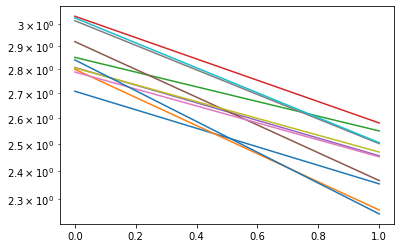

In [340]:
for h in hs:
    if 'val_loss' in h:
        plt.plot(h['val_loss'])
    plt.plot(h['loss'])
# plt.legend([1,2,3,4,5,6])
plt.yscale('log')

In [342]:
pd.read_csv("../src/data/train_NN.txt", sep="|", index_col='ID')


,RGBA_0_VAL_0,RGBA_1_VAL_0,RGBA_2_VAL_0,RGBA_3_VAL_0,RGBA_4_VAL_0,RGBA_5_VAL_0,RGBA_6_VAL_0,RGBA_7_VAL_0,RGBA_8_VAL_0,RGBA_9_VAL_0,...,PROB_6_VAL_4,PROB_0_TOTAL,PROB_1_TOTAL,PROB_2_TOTAL,PROB_3_TOTAL,PROB_4_TOTAL,PROB_5_TOTAL,PROB_6_TOTAL,CLASE,cv_idx
ID,,,,,,,,,,,,,,,,,,,,,
35984B9C3E7CD9A1,-0.096031,0.096968,-0.025451,-0.072411,0.081554,-0.043795,-0.019040,-0.000023,-0.037227,0.052280,...,0.130999,0.120024,0.192381,0.083408,0.092246,0.129681,0.222434,0.159827,RESIDENTIAL,4.0
F9D04BF6D037F8FB,-0.132915,0.059396,-0.043071,0.040773,0.011282,-0.065378,-0.016665,-0.024568,-0.039954,0.028095,...,0.129412,0.093406,0.234615,0.055051,0.057928,0.110943,0.281226,0.166831,RESIDENTIAL,1.0
B89D5711AFF8C423,-0.183661,0.082888,-0.063106,-0.129952,0.092938,0.012040,-0.036319,0.062238,-0.031643,0.082616,...,0.129154,0.123308,0.178743,0.097137,0.107557,0.137985,0.204515,0.150755,RESIDENTIAL,4.0
1C3478AC1522E7E4,-0.095560,0.061815,-0.180316,-0.146279,-0.001434,0.122403,-0.024369,-0.043840,-0.047323,0.045441,...,0.133436,0.139825,0.164564,0.108641,0.106748,0.134553,0.192885,0.152783,RESIDENTIAL,3.0
4D12AA5009064345,0.015255,0.001629,-0.156996,-0.173034,-0.027061,-0.016455,-0.042453,0.139120,-0.041895,0.085724,...,0.134056,0.130227,0.162637,0.141354,0.130291,0.144016,0.152033,0.139441,RESIDENTIAL,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5FD596EB22DB167,-0.060495,0.027530,-0.088452,-0.106976,-0.004730,-0.026896,-0.049652,0.118823,-0.047279,0.064351,...,0.126046,0.133475,0.166884,0.100385,0.113117,0.135003,0.196789,0.154347,RESIDENTIAL,3.0
A51D42F2EAB0E15E,-0.091187,0.062871,0.026972,-0.014763,0.086821,-0.068984,-0.034076,-0.059502,-0.006434,0.031368,...,0.128423,0.121074,0.194629,0.082870,0.086162,0.118600,0.230112,0.166553,RESIDENTIAL,0.0
9B75473FE6396523,0.247702,0.052958,0.235173,-0.013521,0.219809,-0.126160,-0.046940,-0.151154,0.262305,-0.025982,...,0.138693,0.106232,0.222061,0.125454,0.095599,0.122009,0.184002,0.144643,INDUSTRIAL,4.0


((20646, 22), (20646, 10))

In [171]:
h1.history

{}